In [1]:
trace_file = '../out/sim/sequence_length5000/beast-relaxed-fixed.log'
tree_file = '../out/sim/sequence_length5000/beast-relaxed-fixed.trees'
beast_config_file = '../config/beast-config.yaml'
plot_out_file = '../out/sim/sequence_length5000/rate-correlations.png'

(<tf.Variable 'dist_mu:0' shape=() dtype=float32, numpy=3.057471>,
 <tf.Variable 'dist_sd_inv_softplus:0' shape=() dtype=float32, numpy=3.9980178>)

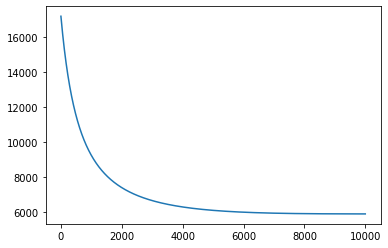

In [153]:
mu = 3
sd = 4
sample_shape = 1000
x = tfp.distributions.LogNormal(mu, sd).sample(sample_shape)
dist = tfp.distributions.Sample(tfp.distributions.LogNormal(
    tf.Variable(0.0, name='dist_mu'),
    tfp.util.DeferredTensor(tf.Variable(tfp.math.softplus_inverse(1.0), name='dist_sd_inv_softplus'), tf.nn.softplus)
), sample_shape)
res = tfp.math.minimize(lambda: -dist.log_prob(x), 10000, tf.optimizers.Adam())
plt.plot(res)
dist.trainable_variables

In [2]:
import pandas as pd
from treeflow_pipeline.util import yaml_input

renaming = {
    "TreeHeight": 'tree_height',
    "popSize": "pop_size", 
    "clockRate": "clock_rate",
    "Tree.treeLength": "tree_length"
}


beast_config = yaml_input(beast_config_file)
burn_in = beast_config['burn_in']

def remove_burn_in(x):
    return x[np.arange(len(x)) > int(len(trace) * burn_in)]

trace = (pd.read_table(trace_file, comment="#")
         .pipe(lambda x: x[list(renaming.keys())])
         .pipe(lambda x: x.rename(columns=renaming))
        )
trace

,tree_height,pop_size,clock_rate,tree_length
0,15.865310,15.604540,0.010761,38.797474
1,15.734642,5.601547,0.011701,37.829674
2,16.151335,6.624020,0.011395,39.364145
3,16.202086,4.181319,0.011566,38.997457
4,16.807179,5.072408,0.011039,41.067360
...,...,...,...,...
9996,16.769871,8.513815,0.010207,42.163139
9997,14.801463,5.978405,0.011245,37.066533
9998,16.064274,6.249105,0.010627,39.825459
9999,16.887560,6.350787,0.010295,43.108978


In [3]:
import dendropy

trees = dendropy.TreeList.get(path=tree_file, schema="nexus", rooting="default-rooted")

In [4]:
import numpy as np

def traverse_leaves_first(tree, f, out=None):
    taxon_count = len(tree.taxon_namespace)
    if out is None:
        out = np.zeros(2 * taxon_count - 1)
    leaf_index = 0
    node_index = taxon_count
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            out[leaf_index] = f(node)
            leaf_index += 1
        else:
            out[node_index] = f(node)
            node_index += 1
    return out

taxon_count = len(trees[0].taxon_namespace)
blens = np.zeros((len(trees), 2 * taxon_count - 1))
rates = np.zeros((len(trees), 2 * taxon_count - 1))

for i, tree in enumerate(trees):
    traverse_leaves_first(tree, lambda x: x.edge.length, out=blens[i])
    traverse_leaves_first(tree, lambda x: float(x.annotations['rate'].value), out=rates[i])

blens[-3:], rates[-3:]

(array([[0.71899482, 5.10541554, 2.44292977, 1.22727111, 0.01780258,
         0.19790398, 1.49745253, 2.06001042, 8.00123281, 3.73758535,
         4.22386285, 0.03687616, 1.96650341, 1.35659619, 0.01374868,
         7.22127275, 0.        ],
        [1.13194903, 5.51836974, 2.67028129, 1.27651162, 0.06704308,
         0.40713382, 1.70223611, 2.30826586, 8.82451891, 3.60976292,
         4.38385219, 0.0324299 , 2.00997526, 1.33569227, 0.07152893,
         7.75942708, 0.        ],
        [0.85897805, 5.24539877, 2.09694549, 1.22426414, 0.01479561,
         0.28884592, 1.58564982, 1.9747155 , 7.27752825, 3.60196239,
         4.31781176, 0.03413151, 1.7930112 , 1.09590683, 0.36409323,
         6.49320792, 0.        ]]),
 array([[0.00972067, 0.00992967, 0.00882567, 0.01030918, 0.01052483,
         0.01569926, 0.0114289 , 0.00975338, 0.00966058, 0.00983638,
         0.01078431, 0.00946017, 0.01137363, 0.01035432, 0.01191912,
         0.01237899, 1.        ],
        [0.00793811, 0.01032645, 0

In [5]:
rates_scaled = rates / trace.clock_rate[:, np.newaxis]
mean_rate_b = remove_burn_in(trace.clock_rate)
rates_b = remove_burn_in(rates)[:, :-1]
rates_scaled_b = remove_burn_in(rates_scaled)[:, :-1]
blens_b = remove_burn_in(blens)[:, :-1]

In [6]:
distances = blens_b * rates_b
mean_distances = np.mean(distances, axis=0)
mean_distances

array([0.00766192, 0.05552311, 0.02182012, 0.0134833 , 0.00033124,
       0.00443489, 0.01864228, 0.02108845, 0.08545529, 0.03411215,
       0.04602183, 0.00041066, 0.02130853, 0.01141638, 0.0016955 ,
       0.07865821])

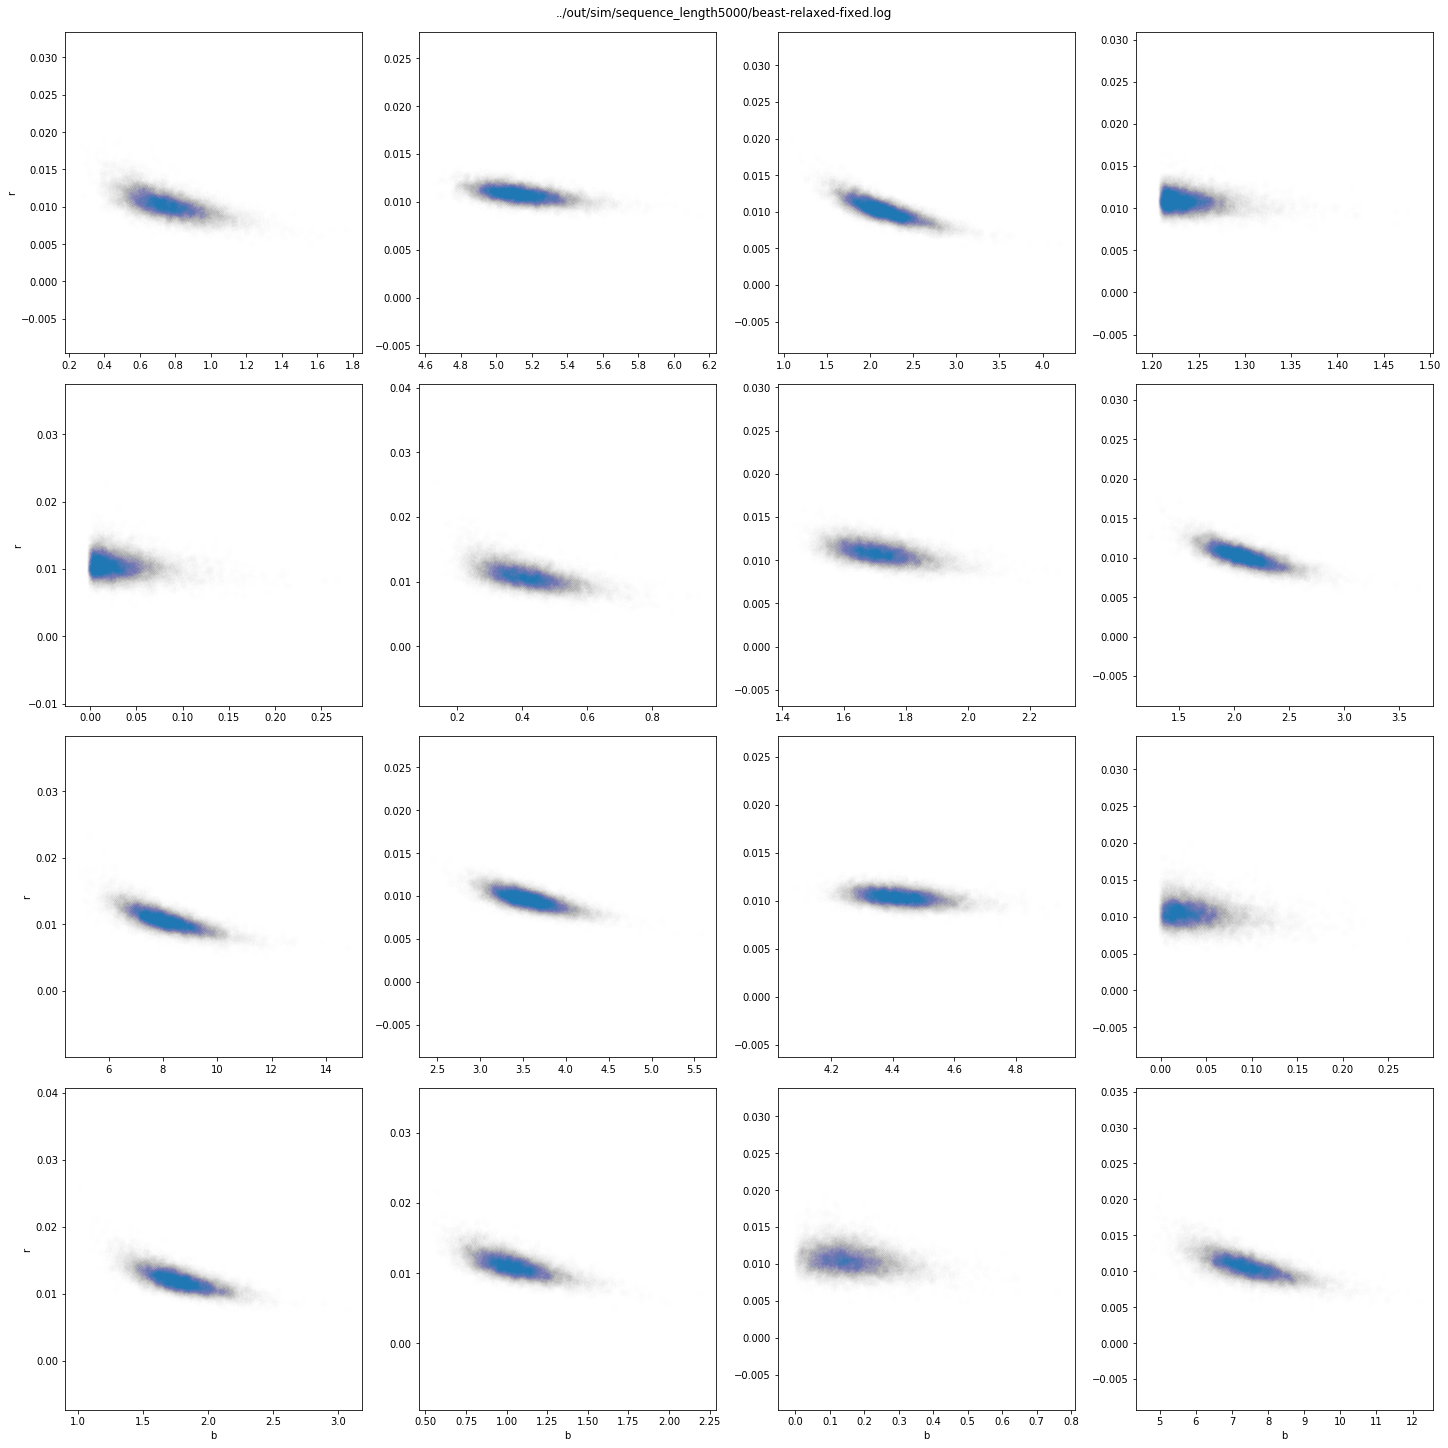

In [85]:
import matplotlib.pyplot as plt

n_cols = 4
n_branches = 2*taxon_count - 2
n_rows = n_branches // n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]
for ax, mean_d, branch_blens, branch_rates in zip(axs_flat, mean_distances, blens_b.T, rates_b.T):
    ax.scatter(branch_blens, branch_rates, alpha=0.005)

for ax in axs[-1]:
    ax.set_xlabel('b')

for row in axs:
    row[0].set_ylabel('r')
    
plt.suptitle(trace_file);
plt.savefig(plot_out_file)

In [99]:
import tensorflow as tf
import tensorflow_probability as tfp


def get_scale_variable(init, name):
    return tfp.util.DeferredTensor(tf.Variable(tfp.math.softplus_inverse(init), name=name), tf.nn.softplus)

def lognormal_ml(x):
    logx = np.log(x)
    return np.mean(logx, axis=0), np.std(logx, axis=0)

init_blen_loc, init_blen_std = lognormal_ml(blens_b)
init_rate_loc, init_rate_std = lognormal_ml(rates_b)

mean_field = tfp.distributions.JointDistributionNamed(dict(
    branch_lengths = tfp.distributions.Independent(tfp.distributions.LogNormal(
        loc=tf.Variable(init_blen_loc, name='mean_field_blen_loc'),
        scale=get_scale_variable(init_blen_std, 'mean_field_blen_scale')
    ), reinterpreted_batch_ndims=0),
    rates = tfp.distributions.Independent(tfp.distributions.LogNormal(
        tf.Variable(init_rate_loc, name='mean_field_rate_loc'), get_scale_variable(init_rate_std, 'mean_field_rate_scale')
    ), reinterpreted_batch_ndims=0)
))

mean_field.log_prob(mean_field.sample())

<tf.Tensor: shape=(16,), dtype=float64, numpy=
array([4.45039114, 7.04213278, 5.46690996, 5.79186456, 7.85703654,
       6.27050457, 6.61589161, 5.77315003, 3.38998714, 3.26928917,
       5.70568976, 8.2424194 , 6.13173622, 5.67971775, 5.83264505,
       0.24643062])>

In [157]:
mean_field.trainable_variables[0].value()

<tf.Tensor: shape=(16,), dtype=float64, numpy=
array([-4.58258473, -4.52988302, -4.58742824, -4.52705584, -4.56390437,
       -4.52930941, -4.52529626, -4.59244904, -4.54713093, -4.64817871,
       -4.56803047, -4.56482965, -4.41919089, -4.50823017, -4.55874675,
       -4.54896976])>

In [158]:
data_dict = {
    'branch_lengths': blens_b,
    'rates': rates_scaled_b
}

class SmallGradientConvergenceCriterion(tfp.optimizer.convergence_criteria.ConvergenceCriterion):
    def _bootstrap(loss, grads, parameters):
        return None
    
    def _one_step()

def fit_approximation(approx):
    return tfp.math.minimize(
        lambda: approx.log_prob(data_dict),
        10000,
    )

#res = fit_approximation(mean_field)
#plt.plot(res[10:])

IndentationError: expected an indented block (<ipython-input-158-a9569f5fa41e>, line 9)

In [122]:
approx_samples = approx.sample(1000)
plot_quantiles = [0.0, 1.0]
def get_meshgrid(i):
    x_range = np.quantile(approx_samples['branch_lengths'], plot_quantiles)
    y_range = np.quantile(approx_samples['rates'], plot_quantiles)
    x = np.linspace(*x_range, 50)
    y = np.linspace(*y_range, 50)
    return np.meshgrid(x, y)
blen_mesh, rates_mesh = [np.stack(x, axis=-1) for x in zip(*[get_meshgrid(i) for i in range(n_branches)])]
prob_mesh = np.exp(mean_field.log_prob(dict(branch_lengths=blen_mesh, rates=rates_mesh)))

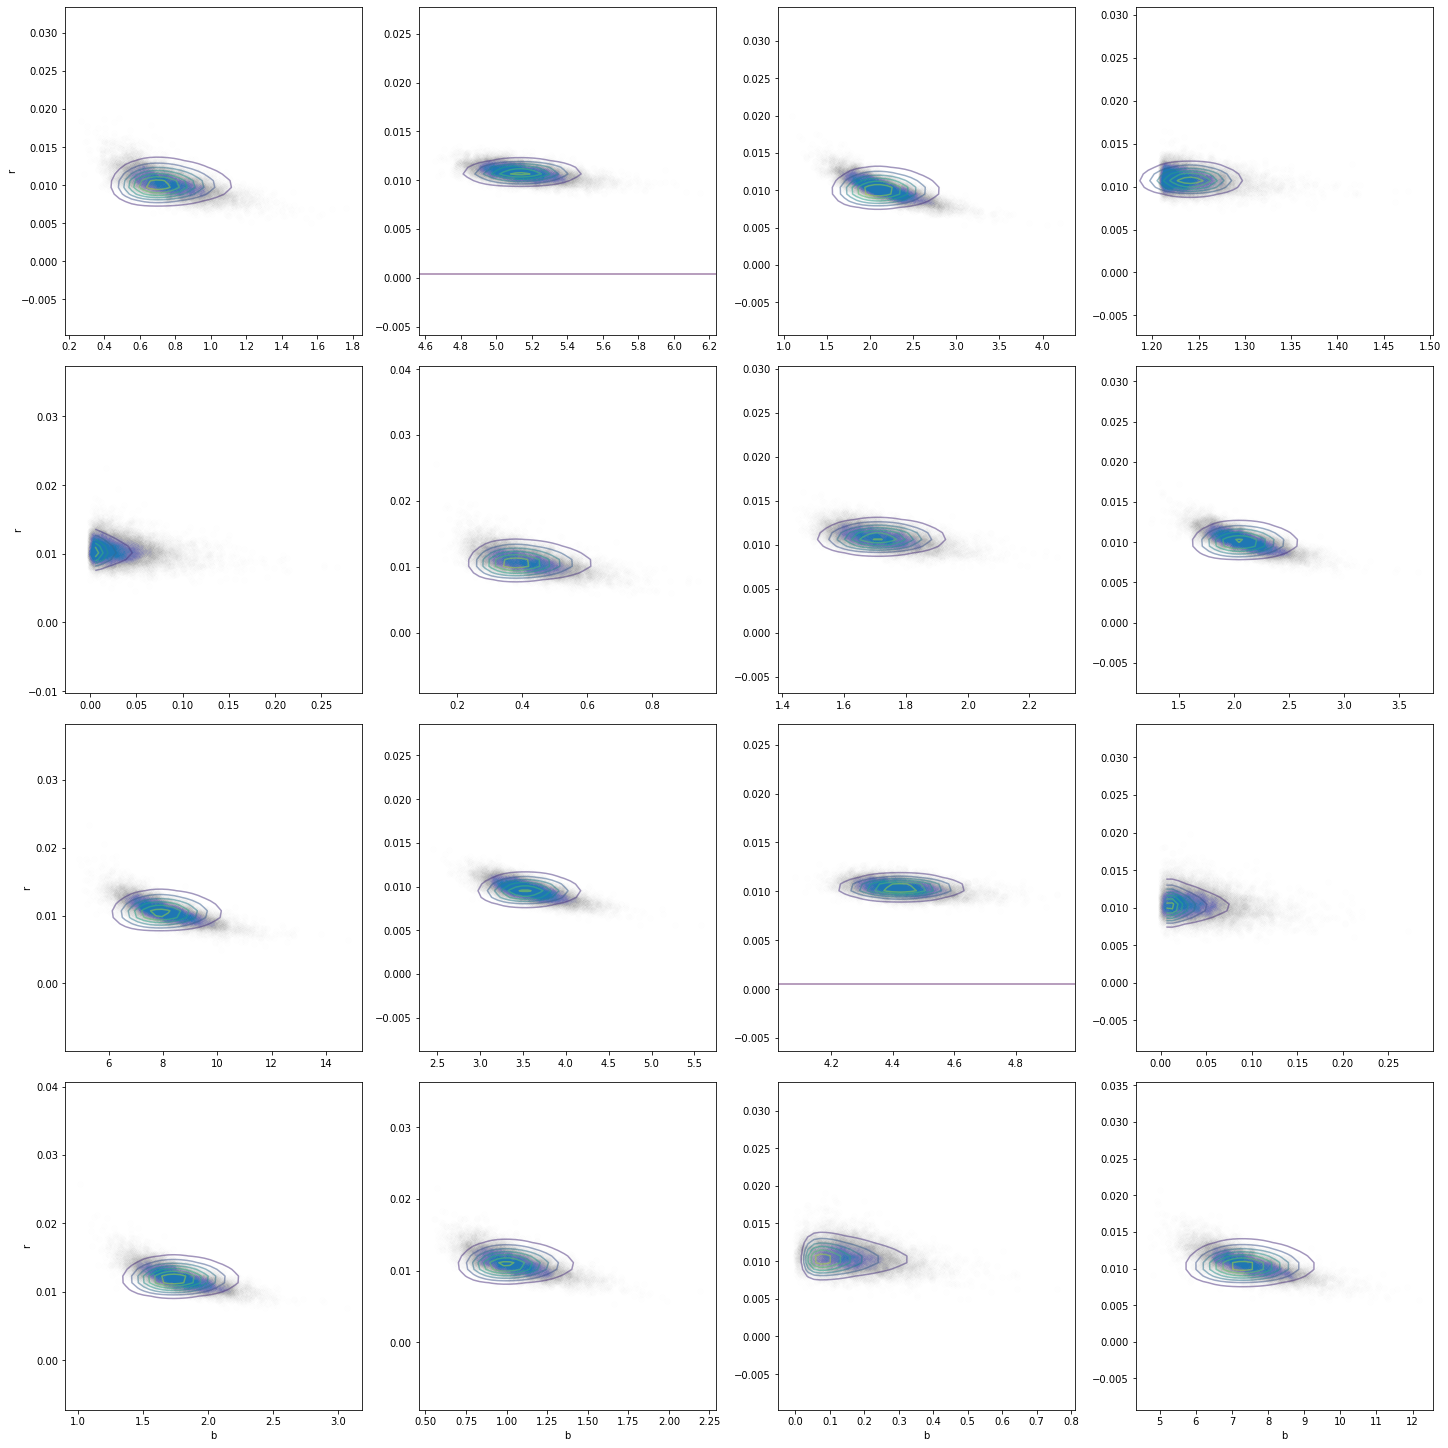

In [144]:
def plot_approximation(approx):
    #approx_samples = approx.sample(1000)
    #plot_quantiles = [0.0, 1.0]
    def get_meshgrid(i, ax):
        x_range = ax.get_xlim()#np.quantile(approx_samples['branch_lengths'], plot_quantiles)
        y_range = ax.get_ylim()#np.quantile(approx_samples['rates'], plot_quantiles)
        x = np.linspace(*x_range, 50)
        y = np.linspace(*y_range, 50)
        return np.meshgrid(x, y)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
    axs_flat = [ax for row in axs for ax in row]
    for ax, branch_blens, branch_rates in zip(axs_flat, blens_b.T, rates_b.T):
        ax.scatter(branch_blens, branch_rates, alpha=0.005) 
        
    
    blen_mesh, rates_mesh = [np.stack(x, axis=-1) for x in zip(*[get_meshgrid(i, ax) for i, ax in enumerate(axs_flat)])]
    prob_mesh = np.exp(mean_field.log_prob(dict(branch_lengths=blen_mesh, rates=rates_mesh)))
    
    for i, ax in enumerate(axs_flat):
        ax.contour(blen_mesh[..., i], rates_mesh[..., i], prob_mesh[..., i], alpha=0.5)
    
    for ax in axs[-1]:
        ax.set_xlabel('b')

    for row in axs:
        row[0].set_ylabel('r')

plot_approximation(mean_field)